# Задача 5. Обучение без учителя

## Задача

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x] (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Датасет

В качестве датасета будем использовать https://www.kaggle.com/datasets/zalando-research/fashionmnist. Он состоит из обучающего набора из 60 000 примеров и тестового набора из 10 000 примеров черно-белых изображений 28x28 пикселей, содержащий различные вещи гардероба. Всего существует 10 различных классов вещей:

0.   T-shirt/top
1.   Trouser
2.   Pullover
3.   Dress
4.   Coat
5.   Sandal
6.   Shirt
7.   Sneaker
8.   Bag
9.   Ankle boot

Будем решать на этом датасете задачу кластеризации

In [60]:
df = pd.read_csv('fashion-mnist_test.csv')

In [61]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
labels = df["label"]
labels.value_counts()

0    1000
1    1000
2    1000
3    1000
8    1000
6    1000
5    1000
4    1000
7    1000
9    1000
Name: label, dtype: int64

Элементов каждого класса одинаково. Поэтому размеры кластеров должны быть примерно одинаковы. 

In [63]:
df.drop(columns=['label'], inplace=True)

Удаляем колонку label из тренировочного датасета

#Eda

#Визуализация с помощью PCA

In [64]:
from sklearn.decomposition import PCA
pca = PCA()

pca_df = pca.fit_transform(df)

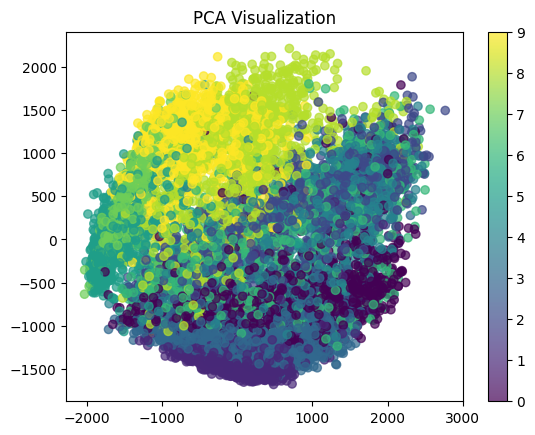

In [20]:
plt.scatter(pca_df[:,0], pca_df[:,1], c=labels, alpha=0.7)
plt.colorbar();
plt.title('PCA Visualization');

#Визуализация с помощью t-SNE

In [21]:
from sklearn.manifold import TSNE
tsne_df = TSNE().fit_transform(df)

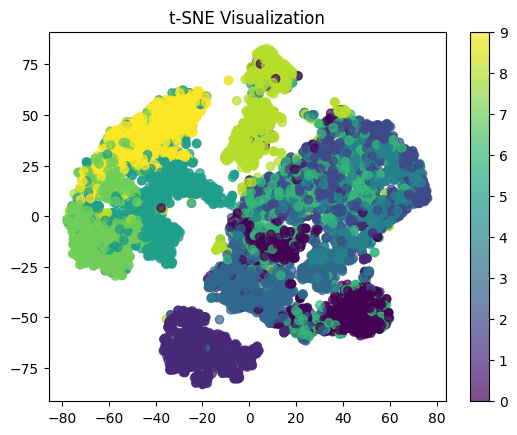

In [22]:
plt.scatter(tsne_df[:,0], tsne_df[:,1], c=labels, alpha=0.7)
plt.colorbar();
plt.title('t-SNE Visualization');

#Понижение размерности

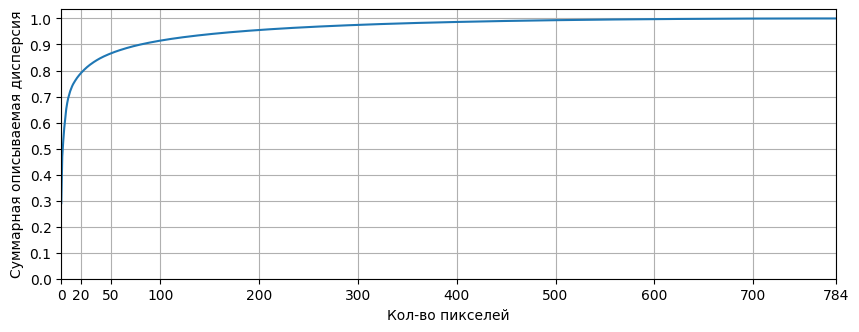

In [23]:
plt.figure(figsize=(10,3.5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Кол-во пикселей")
plt.ylabel("Суммарная описываемая дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks([*plt.xticks()[0], 20, 50, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)

#Обучение

### Собственная реализация K-**Means**

In [65]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator


class MyKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        X = check_array(X)

        self.n_features_in_ = X.shape[1]

        self.cluster_centers_ = X[
            self.random_state_.choice(len(X), size=self.n_clusters, replace=False), :
        ]

        max_center_shift = np.inf
        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(X)

            new_centers = np.empty((self.n_clusters, self.n_features_in_))
            for label in np.unique(self.labels_):
                new_centers[label] = np.mean(X[self.labels_ == label], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))

            self.cluster_centers_ = new_centers

        return self

    def predict(self, X):
        check_is_fitted(self)
        return self._get_labels(check_array(X))
    
    def _get_labels(self, X):
        return np.argmin(
            np.linalg.norm(X[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )


###Метрики

*   Fowlkes-Mallows Index (FMI)
*   Adjusted Mutual Information (AMI)
*   Adjusted Rand Index (ARI)


In [66]:
%%time
xs = [df, *(PCA(n_components=d).fit_transform(df) for d in [20, 50, 100, 500])]

CPU times: user 12.7 s, sys: 5.19 s, total: 17.9 s
Wall time: 11.3 s


In [70]:
import itertools, time
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.base import clone

def train(est, params):
    params_combs = [
        dict(param) for param in
        itertools.product(*([(name, v) for v in vs] for (name, vs) in params.items()))
    ]

    results = []
    for x in xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for param in params_combs:
            e = clone(est).set_params(**param)
            start_time = time.perf_counter()
            pred = e.fit_predict(x)
            pred_time = (time.perf_counter() - start_time)

            ari = adjusted_rand_score(labels, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, pred_time, param

            ami = adjusted_mutual_info_score(labels, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, pred_time, param

            fmi = fowlkes_mallows_score(labels, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, pred_time, param

        res = {
            "cluster": est.__class__.__name__,
            "dimension": x.shape[1],
            "mean fit predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
            "best ari": best_ari[0],
            "best ami": best_ami[0],
            "best fmi": best_fmi[0]
        }

        print(res)
        results.append(res)

    return results

In [71]:
%%time

train(MyKMeans(random_state=0),
              params={})

{'cluster': 'MyKMeans', 'dimension': 784, 'mean fit predict time, s': 17.853298117999657, 'best ari': 0.3593834287098087, 'best ami': 0.49294311449682093, 'best fmi': 0.42652077024966184}
{'cluster': 'MyKMeans', 'dimension': 20, 'mean fit predict time, s': 0.38747800500095764, 'best ari': 0.3576459455243257, 'best ami': 0.49127668475294023, 'best fmi': 0.4250224480023388}
{'cluster': 'MyKMeans', 'dimension': 50, 'mean fit predict time, s': 1.1466099379995285, 'best ari': 0.35896656848573855, 'best ami': 0.4927135838991002, 'best fmi': 0.4261125742774141}
{'cluster': 'MyKMeans', 'dimension': 100, 'mean fit predict time, s': 1.7832129310008895, 'best ari': 0.3592355833187087, 'best ami': 0.4928329761526502, 'best fmi': 0.4263755639020018}
{'cluster': 'MyKMeans', 'dimension': 500, 'mean fit predict time, s': 9.148323383000388, 'best ari': 0.3593834287098087, 'best ami': 0.49294311449682093, 'best fmi': 0.42652077024966184}
CPU times: user 17.3 s, sys: 13 s, total: 30.3 s
Wall time: 30.4 s

[{'cluster': 'MyKMeans',
  'dimension': 784,
  'mean fit predict time, s': 17.853298117999657,
  'best ari': 0.3593834287098087,
  'best ami': 0.49294311449682093,
  'best fmi': 0.42652077024966184},
 {'cluster': 'MyKMeans',
  'dimension': 20,
  'mean fit predict time, s': 0.38747800500095764,
  'best ari': 0.3576459455243257,
  'best ami': 0.49127668475294023,
  'best fmi': 0.4250224480023388},
 {'cluster': 'MyKMeans',
  'dimension': 50,
  'mean fit predict time, s': 1.1466099379995285,
  'best ari': 0.35896656848573855,
  'best ami': 0.4927135838991002,
  'best fmi': 0.4261125742774141},
 {'cluster': 'MyKMeans',
  'dimension': 100,
  'mean fit predict time, s': 1.7832129310008895,
  'best ari': 0.3592355833187087,
  'best ami': 0.4928329761526502,
  'best fmi': 0.4263755639020018},
 {'cluster': 'MyKMeans',
  'dimension': 500,
  'mean fit predict time, s': 9.148323383000388,
  'best ari': 0.3593834287098087,
  'best ami': 0.49294311449682093,
  'best fmi': 0.42652077024966184}]

In [72]:
%%time
from sklearn.cluster import KMeans

train(KMeans(n_clusters=10, n_init='auto', random_state=0),
               params={"algorithm": ["lloyd", "elkan"]})

{'cluster': 'KMeans', 'dimension': 784, 'mean fit predict time, s': 2.309687410001061, 'best ari': 0.3804757125830627, 'best ami': 0.5159447484764907, 'best fmi': 0.4464502780896524}
{'cluster': 'KMeans', 'dimension': 20, 'mean fit predict time, s': 0.07700609499988786, 'best ari': 0.3932473483810594, 'best ami': 0.5328731000917557, 'best fmi': 0.45857678827913373}
{'cluster': 'KMeans', 'dimension': 50, 'mean fit predict time, s': 0.17069507700034592, 'best ari': 0.3304398798146397, 'best ami': 0.5027140072395503, 'best fmi': 0.4023497910588416}
{'cluster': 'KMeans', 'dimension': 100, 'mean fit predict time, s': 0.1464727419988776, 'best ari': 0.3421837034857811, 'best ami': 0.5071759239286876, 'best fmi': 0.41492853438384836}
{'cluster': 'KMeans', 'dimension': 500, 'mean fit predict time, s': 0.6013092489993141, 'best ari': 0.381602722879035, 'best ami': 0.5133462707409182, 'best fmi': 0.4456152971294334}
CPU times: user 8.74 s, sys: 922 ms, total: 9.66 s
Wall time: 5.96 s


[{'cluster': 'KMeans',
  'dimension': 784,
  'mean fit predict time, s': 2.309687410001061,
  'best ari': 0.3804757125830627,
  'best ami': 0.5159447484764907,
  'best fmi': 0.4464502780896524},
 {'cluster': 'KMeans',
  'dimension': 20,
  'mean fit predict time, s': 0.07700609499988786,
  'best ari': 0.3932473483810594,
  'best ami': 0.5328731000917557,
  'best fmi': 0.45857678827913373},
 {'cluster': 'KMeans',
  'dimension': 50,
  'mean fit predict time, s': 0.17069507700034592,
  'best ari': 0.3304398798146397,
  'best ami': 0.5027140072395503,
  'best fmi': 0.4023497910588416},
 {'cluster': 'KMeans',
  'dimension': 100,
  'mean fit predict time, s': 0.1464727419988776,
  'best ari': 0.3421837034857811,
  'best ami': 0.5071759239286876,
  'best fmi': 0.41492853438384836},
 {'cluster': 'KMeans',
  'dimension': 500,
  'mean fit predict time, s': 0.6013092489993141,
  'best ari': 0.381602722879035,
  'best ami': 0.5133462707409182,
  'best fmi': 0.4456152971294334}]

In [73]:
%%time
from sklearn.cluster import DBSCAN

train(DBSCAN(n_jobs=-1), # use all processors 
               params={"eps": [400, 800, 1200],
                            "min_samples": [20, 40, 80]})

{'cluster': 'DBSCAN', 'dimension': 784, 'mean fit predict time, s': 7.9412327200006985, 'best ari': 0.050951223618502774, 'best ami': 0.11960471781036905, 'best fmi': 0.31608541725157124}
{'cluster': 'DBSCAN', 'dimension': 20, 'mean fit predict time, s': 0.33844290699926205, 'best ari': 0.049906524187654344, 'best ami': 0.2779391926146442, 'best fmi': 0.31675328601444624}
{'cluster': 'DBSCAN', 'dimension': 50, 'mean fit predict time, s': 0.47842456966706476, 'best ari': 0.08540022448157682, 'best ami': 0.28707082293763403, 'best fmi': 0.31608541725157124}
{'cluster': 'DBSCAN', 'dimension': 100, 'mean fit predict time, s': 0.768397966666574, 'best ari': 0.07544279101205398, 'best ami': 0.29105229016574224, 'best fmi': 0.31608541725157124}
{'cluster': 'DBSCAN', 'dimension': 500, 'mean fit predict time, s': 3.1788785190001363, 'best ari': 0.048572432463724516, 'best ami': 0.12641434837304635, 'best fmi': 0.31608541725157124}
CPU times: user 3min, sys: 7.04 s, total: 3min 7s
Wall time: 1mi

[{'cluster': 'DBSCAN',
  'dimension': 784,
  'mean fit predict time, s': 7.9412327200006985,
  'best ari': 0.050951223618502774,
  'best ami': 0.11960471781036905,
  'best fmi': 0.31608541725157124},
 {'cluster': 'DBSCAN',
  'dimension': 20,
  'mean fit predict time, s': 0.33844290699926205,
  'best ari': 0.049906524187654344,
  'best ami': 0.2779391926146442,
  'best fmi': 0.31675328601444624},
 {'cluster': 'DBSCAN',
  'dimension': 50,
  'mean fit predict time, s': 0.47842456966706476,
  'best ari': 0.08540022448157682,
  'best ami': 0.28707082293763403,
  'best fmi': 0.31608541725157124},
 {'cluster': 'DBSCAN',
  'dimension': 100,
  'mean fit predict time, s': 0.768397966666574,
  'best ari': 0.07544279101205398,
  'best ami': 0.29105229016574224,
  'best fmi': 0.31608541725157124},
 {'cluster': 'DBSCAN',
  'dimension': 500,
  'mean fit predict time, s': 3.1788785190001363,
  'best ari': 0.048572432463724516,
  'best ami': 0.12641434837304635,
  'best fmi': 0.31608541725157124}]

In [76]:
results = pd.DataFrame(my_k_mean + k_mean + dbscan)

#Результаты

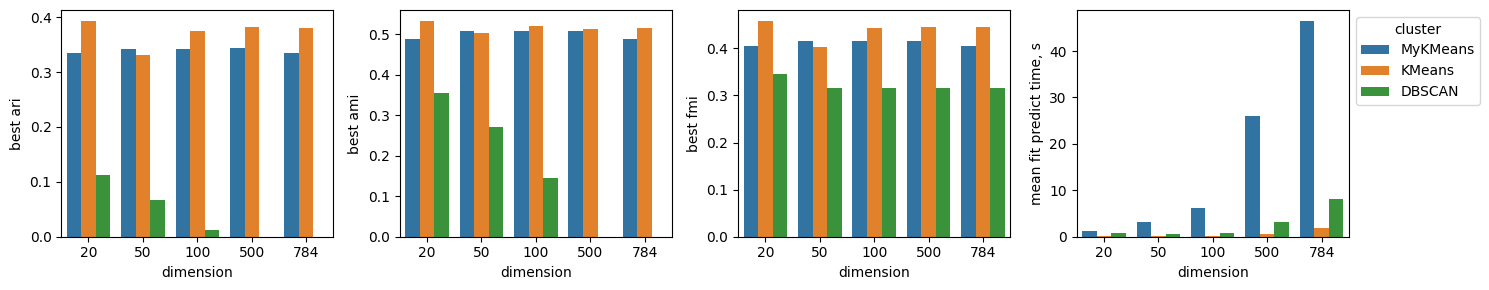

In [75]:
import seaborn as sns

fig, axs = plt.subplots(ncols=4, figsize=(15, 3))

for metric, ax in zip(["best ari", "best ami", "best fmi", "mean fit predict time, s"], axs.flatten()):
    sns.barplot(results, x="dimension", y=metric, hue="cluster", ax=ax)
    if metric == "mean fit predict time, s":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()

fig.tight_layout()

###Результаты:
1.   Уменьшение размерности данных почти не сказалось на качестве предсказаний.
2.   **Скорость:** MyKMeans оказался самым медленным, а самым быстрым оказался KMeans из библиотеки sklearn.
3. **Качество:** DBSCAN проигрывает KMeans и MyKMeans по всем метрикам. Тогда как MyKMeans оказывалась почти всегда чуть хуже KMeans.



